# **➼ Enrique Andres Rojas Alvarez**

## **➼ Codigo Preguna N°1**

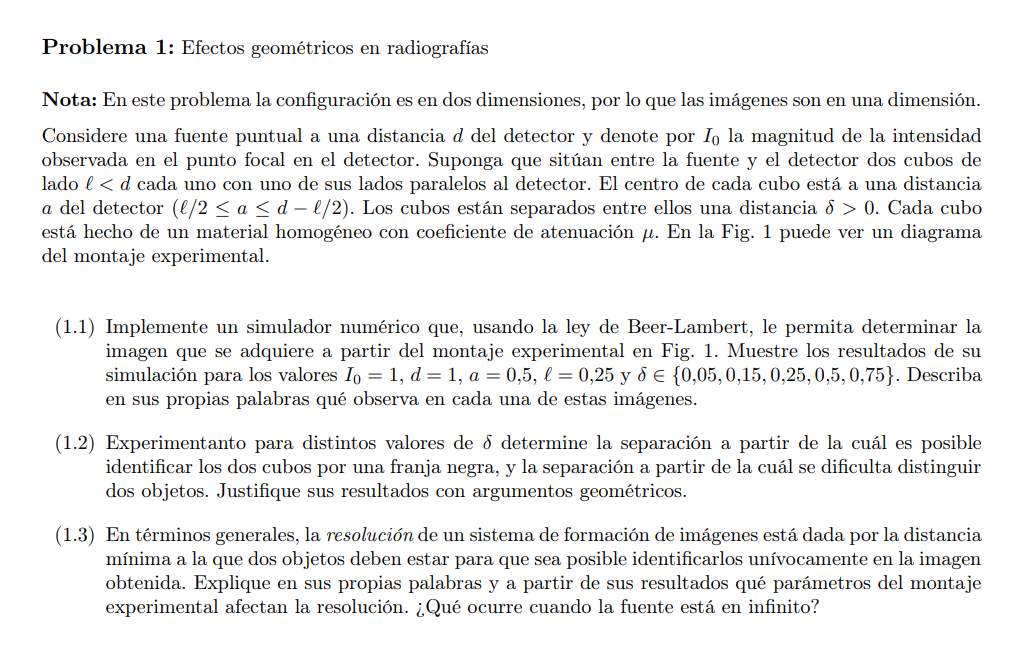



##¡¡ Para el desarrollo de esta pregunta se asumira que los 2 cubos parten desde el mismo eje !!

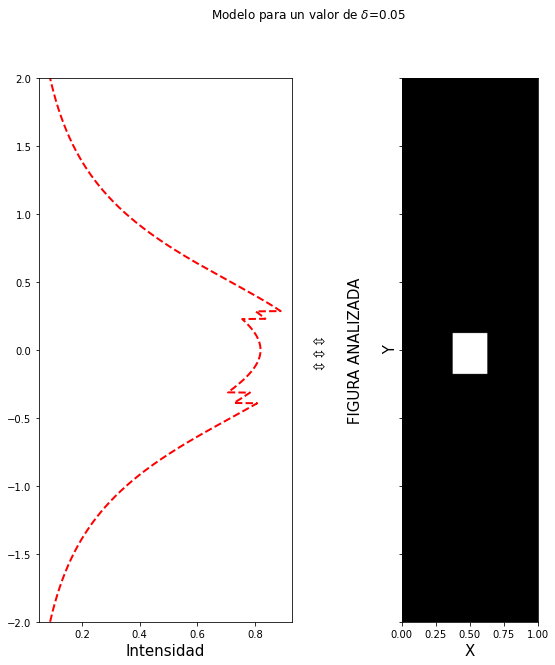

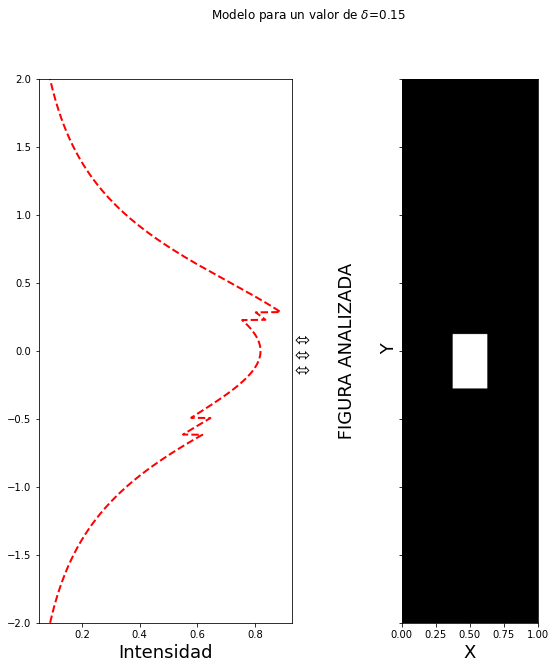

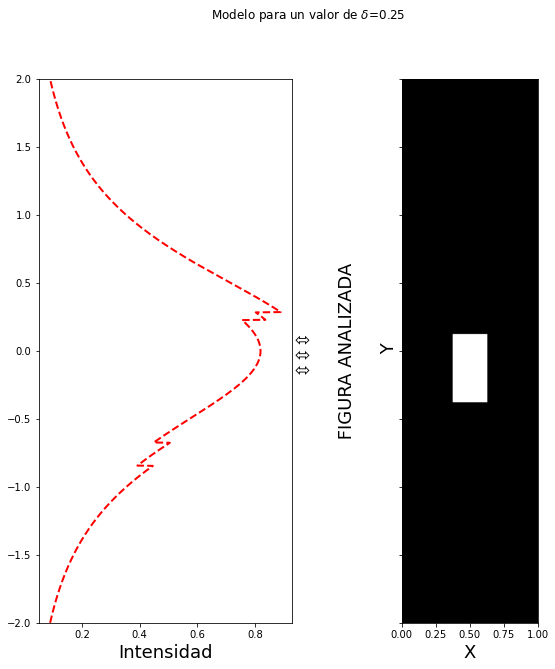

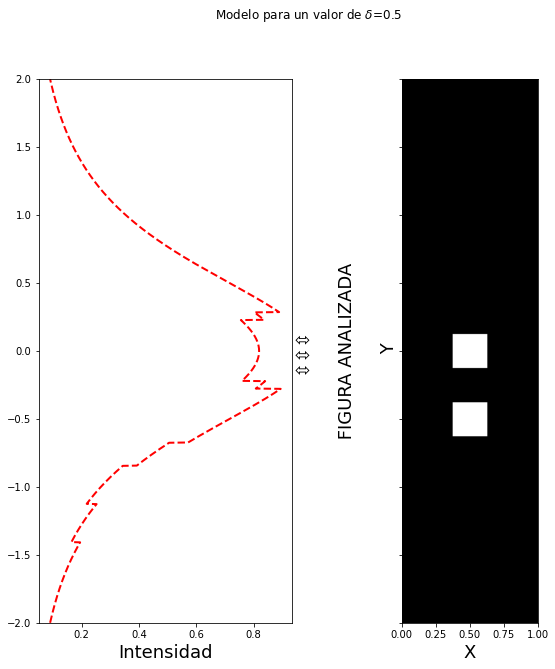

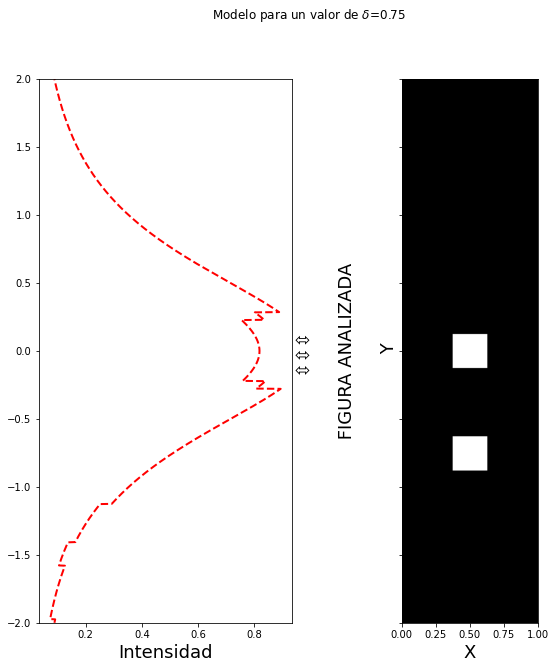

In [ ]:
#########################################################################################################################################################################################################################################################################
#Librerias 
import numpy as np
from scipy import ndimage
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp2d
from scipy.ndimage import map_coordinates

#########################################################################################################################################################################################################################################################################
def interpolate(data, pos, func = "lin"):
    if func == "lin":
        pos_br = tuple(np.ceil(pos[:2]).astype(int))
        pos_bl = tuple(np.array([np.floor(pos[0]), np.ceil(pos[1])]).astype(int))
        pos_tr = tuple(np.array([np.ceil(pos[0]), np.floor(pos[1])]).astype(int))
        pos_tl = tuple(np.floor(pos[:2]).astype(int))

        try:
            br = data[pos_br]
        except IndexError:
            br = np.array([0, 0, 0])
        try:
            bl = data[pos_bl]
        except IndexError:
            bl = np.array([0, 0, 0])
        try:
            tr = data[pos_tr]
        except IndexError:
            tr = np.array([0, 0, 0])
        try:
            tl = data[pos_tl]
        except IndexError:
            tl = np.array([0, 0, 0])
        
        out = tl*((pos_br[0] - pos[0])*(pos_br[1] - pos[1])) + \
            tr*((pos[0] - pos_bl[0])*(pos_bl[1] - pos[1])) + \
            bl*((pos_tr[0] - pos[0])*(pos[1] - pos_tl[1])) + \
            br*((pos[0] - pos_tl[0])*(pos[1] - pos_tl[1]))
        if len(data.shape) < 3 and out.shape:
            return out[0]
        return out.astype(int)
    
    if func == "near":
        try:
            return data[tuple(np.round(pos[:2]).astype(int))]
        except IndexError:
            if len(data.shape) != 3:
                return 0
            else:
                return np.array([0, 0, 0])
#########################################################################################################################################################################################################################################################################
def afine_transforma(_img, transform, inter = "lin"):
    pos = np.array([[i, j, 1] for i in range(0,_img.shape[0]) for j in range (0,_img.shape[1])])
    dest = np.dot(transform, pos.T)
    print(dest.shape)
    _rotIma = np.zeros(_img.shape)
    for i in range(_img.shape[0]):
        for j in range(_img.shape[1]):
            origpos = dest[:, j+i*_img.shape[1]]
            if origpos[0] >= _img.shape[0] or origpos[1] >= _img.shape[1] or origpos[0] < 0 or origpos[1] < 0:
                pass
            else:
                _rotIma[i,j] = interpolate(_img, origpos, func=inter)
    return _rotIma
#########################################################################################################################################################################################################################################################################
def rot(_img, theta, center = None, deg=True, inter = "lin"):

    if deg: 
        theta *= np.pi/180 
    if center == None:
        vx, vy = _img.shape[:2]
        vx *= -0.5
        vy *= -0.5
    else:
        vx, vy = center

    rotaMat = np.array([[ np.cos(theta), -np.sin(theta), 0],
                        [ np.sin(theta),  np.cos(theta), 0],
                        [             0,              0, 1]])

    tranMat = np.array([[ 1, 0, vx],
                        [ 0, 1, vy],
                        [ 0, 0,  1]])

    transform = np.dot(np.linalg.inv(tranMat), np.dot(rotaMat, tranMat))
    
    _rotIma = ndimage.affine_transform(_img, transform, mode="constant") 

    return _rotIma
#########################################################################################################################################################################################################################################################################
def translate(_img, loc, inter = "lin"):
    vx, vy = loc
    tranMat = np.array([[ 1,  0,  vx],
                        [ 0,  1,  vy],
                        [ 0,  0,  1]])

    _tranIma = ndimage.affine_transform(_img, tranMat, mode="constant")

    return _tranIma
#########################################################################################################################################################################################################################################################################
def place_at(img, loc, angle=0, scale=1, center=None):
    if not center:
        cx, cy = center_of_mass(img)
    else:
        cx, cy = center
    x, y = loc
    scale = 1/scale
    rotaMat = np.array([[ np.cos(angle), -np.sin(angle), 0],
                        [ np.sin(angle),  np.cos(angle), 0],
                        [             0,              0, 1]])
    trans_center = np.array([[1, 0, cy], [0, 1, cx], [0, 0, 1]])
    t1 = np.array([[scale, 0, scale*x], [0, scale, scale*y], [0, 0, 1]])
    trans = np.dot(trans_center, np.dot(rotaMat, t1))
    return ndimage.affine_transform(img, trans, mode="constant", order=1, prefilter=False) 
#########################################################################################################################################################################################################################################################################
def pad(_img, num=(0, 0)):
    dest = np.zeros((_img.shape[0] + num[0], _img.shape[1] + num[1]))
    dest[:_img.shape[0],:_img.shape[1]] = _img
    return dest
#########################################################################################################################################################################################################################################################################
def scale(_img, s=1, inter = "lin"):
    transform = np.array([[ 1/s, 0, 0],
                          [ 0, 1/s, 0],
                          [ 0,   0, 1]])

    _sclImag = ndimage.affine_transform(_img, transform, mode="constant")
    return _sclImag
#########################################################################################################################################################################################################################################################################
def new_shape(_img, shape=(0,0)):

    dest = np.zeros(shape+(3,))
    dest[:_img.shape[0],:_img.shape[1]] = _img
    return dest
#########################################################################################################################################################################################################################################################################
def center_of_mass(_img):
    M = np.sum(_img)
    pos = np.array([[i, j] for i in range(0,_img.shape[0]) for j in range (0,_img.shape[1])])
    cx = (1/M)*np.sum(np.dot(pos[:, 0], _img.flatten()))
    cy = (1/M)*np.sum(np.dot(pos[:, 1], _img.flatten()))
    return cx, cy
#########################################################################################################################################################################################################################################################################
class  Simulador():
    def __init__(self, mu, I0 = 1, d = None, FOV = None, size = ([-5, 5], [-5, 5]), N = 512):
        self.N = N
        self.size = size
        self.xr, self.yr = self.size
        if not FOV:
            FOV  = np.max(self.yr)
        if not d:
            d = self.xr[1]
        self.FOV = FOV
        self.d = d
        self.mu = mu
        self.I0 = I0 
        self._x = np.linspace(self.xr[0]+0.01, self.xr[1]-0.01, self.N)
        self._y = np.linspace(self.yr[0]+0.01, self.yr[1]-0.01, self.N)
        self.p = np.linspace(-self.FOV/2, self.FOV/2, N)
        self.univ = self.calc_mu()
        self.out = self.get_detection()

    def get_detection(self):
        p = self.p
        d = self.d
        fu_isotropica = self.I0/(p**2 + d**2)
        geom = np.sqrt(1+(p/d)**2)
        medicion = (d/np.sqrt(p**2 + d**2))
        integral = np.zeros_like(self.p)
        steps = 10
        sm = 0
        for i, pp in enumerate(self.p):
            sm = 0
            for xx in np.linspace(0, d, steps):
                yy = xx*pp/d
                ii = self.N*(xx - self.xr[0])/(self.xr[1]-self.xr[0])
                jj = self.N*(yy - self.yr[0])/(self.yr[1]-self.yr[0])
                sm +=  self.univ[int(jj)-1, int(ii)-1]
            integral[i] = sm/steps
        return fu_isotropica*medicion*np.exp(-geom*integral)
        
    def calc_mu(self):
        x, y = np.meshgrid(self._x, self._y)
        return self.mu(x, y)


    def plot(self, save = None, title = None):
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(10, 10))
        parameters = {'axes.labelsize': 18 ,'axes.titlesize': 18}
        plt.rcParams.update(parameters)
        ax1.plot(self.out, self.p, color="red",lw=2,linestyle="--")
        ax1.set_xlabel('Intensidad')
        ax2.imshow(self.univ, extent = self.size[0] + self.size[1], cmap = 'gray',  origin='lower')
        ax2.set_ylabel(f"⇳⇳⇳ \n\n FIGURA ANALIZADA \n\n Y",)
        ax2.set_xlabel('X')

        if type(title) == str:
            fig.suptitle(title)
        else:
            fig.suptitle('')
        
        if type(save) == str:
            fig.savefig(save, bbox_inches = 'tight')
        return fig    
#########################################################################################################################################################################################################################################################################
a, h = 1, 0.5
def f(x, y):
    out = (np.abs(x - a) < h/2 ) 
    return out
#########################################################################################################################################################################################################################################################################
sim = Simulador(f)
I0, d, a, l = 1, 1, 0.5, 0.25
delta = 0.1
u = 1
#########################################################################################################################################################################################################################################################################
def cube(x, y):
    out = u*(((np.abs(x - a) < l/2) * (np.abs(y) < l/2)) +
             ((np.abs(x - a) < l/2) * (np.abs(y + delta) < l/2))
             )
    return out
#########################################################################################################################################################################################################################################################################
#1.1
#########################################################################################################################################################################################################################################################################
j = 0
for i in [0.05, 0.15, 0.25, 0.5, 0.75]:
    delta = i
    sim1 = Simulador(cube, d = d, size = ([0, d], [-2, 2]), FOV = 4, N = 1024*2)
    sim1.plot('prob1_delta{}.png'.format(j), title = r'Modelo para un valor de $δ$={}'.format(i))
    j += 1
#########################################################################################################################################################################################################################################################################


#1.1

###En primera instancia lo que debemos notar es que a medida que el valor de delta aumenta se vuelva cada vez mas facil poder discriminar entre cada una de las fijuras, y por contra parte, cuando este disminiye ocurre un fenomeno de superposicion de los cuerpos dado a el aungulo de apertura entre los cuadrados genera que rayos se superpongan y se mezclen en el receptor. 

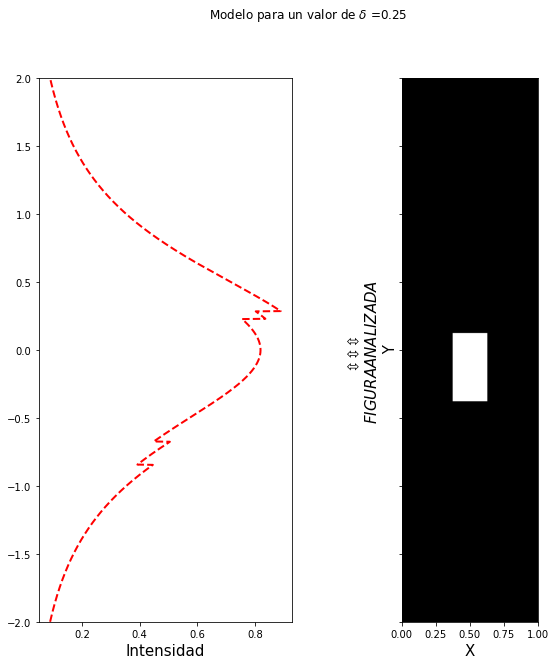

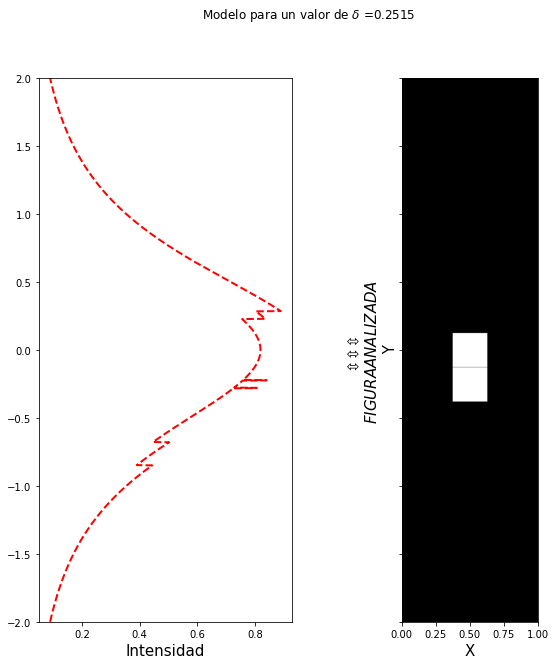

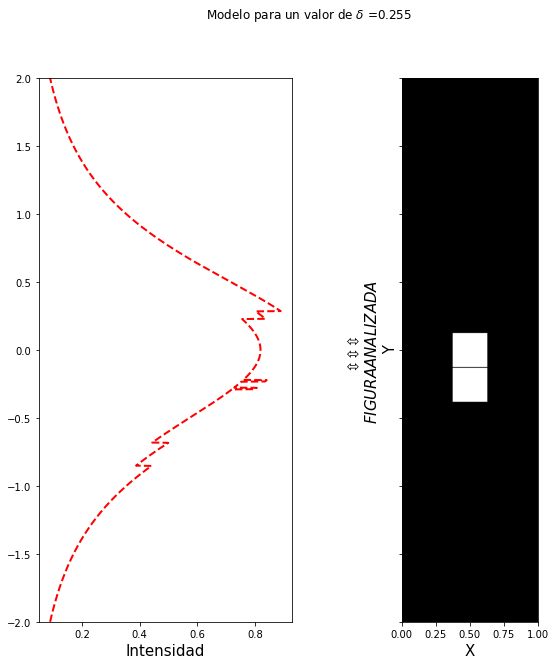

In [ ]:
#1.2
#########################################################################################################################################################################################################################################################################
for i in [ 0.25, 0.2515, 0.255]:
    delta = i
    simEx = Simulador(cube, d = d, size = ([0, d], [-2, 2]), FOV = 4, N = 1024*2)
    simEx.plot('prob1_delta{}.png'.format(j), title = r'Modelo para un valor de $δ$ ={}'.format(i))

    j += 1
#########################################################################################################################################################################################################################################################################


#1.2
### El argumento geométrico que plantea el problema se debe a que al calcular la tangente en base a la distancia del resonar y la separación entre los cuadrados se obtiene un angulo tal que los rayos no logran pasar de manera espaciada por el sistema, generando asi que se produzca una superposición, como podemos evidenciar el valor critico por con el cual se puede diferenciar un cuadrado del otro es 0.2515, es decir si se tiene Valores superiores a este se logra formar una linea solida entre los cuadrados (ejemplo 0.255) y por contraposición si se tiene valores inferiores a este se produce una union de los cuerpos (ejemplo 0.25). Cabe mencionar que al presentarse una divicion entre los cuadrados se genera un pick en intencidad, el cual se acorta cuando el desta es mayor o igual a 0.2515
 


#1.3
###Cuando la fuente está en el infinito nos estamos enfrentando a un caso el angulo que se formara tenderá a 0 en funcion de como se aleja el resonador, generando asi que los rayos se superpongan y que se vuelva cada vez mas difícil poder diferenciar entre un cuerpo y otro.
 
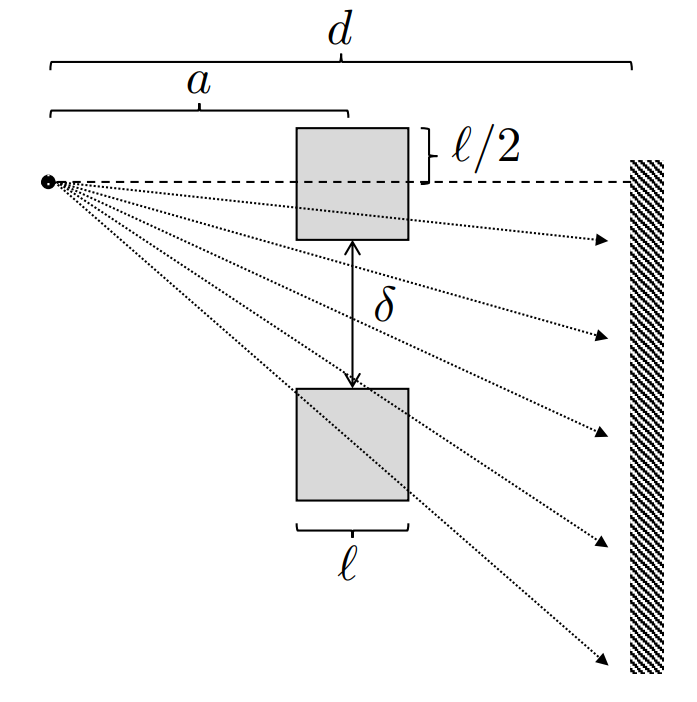

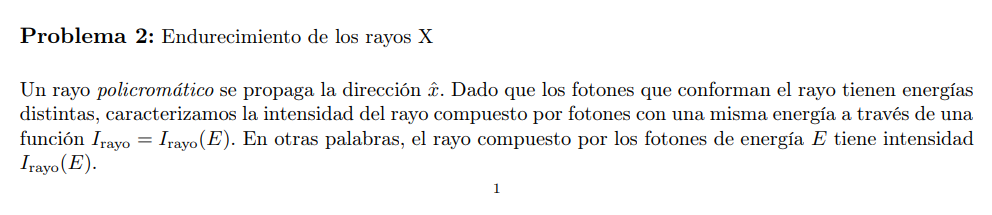

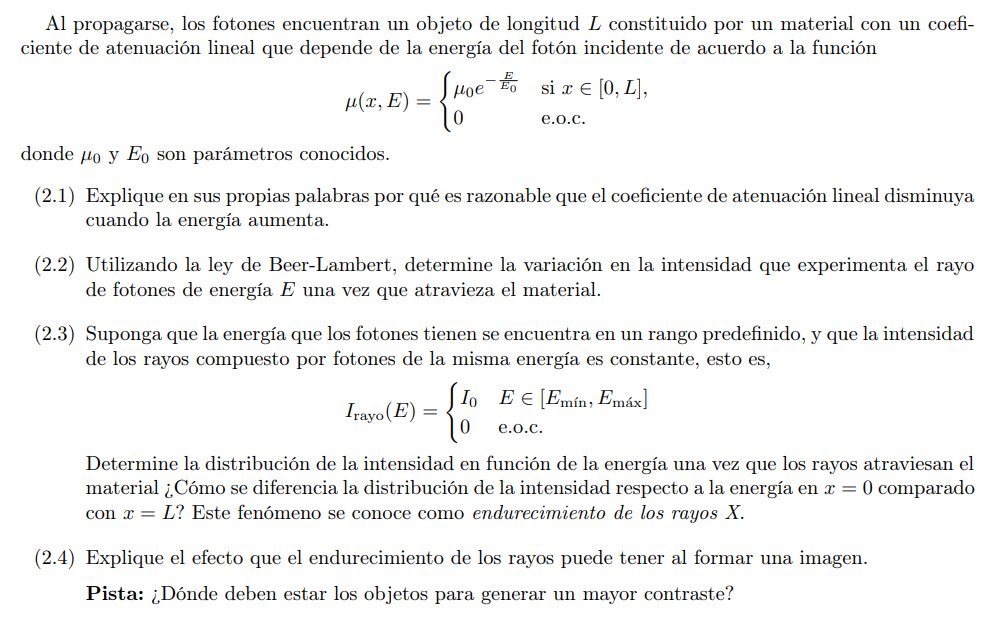


# 2.1

###En primer lugar hemos de entender que el propio comportamiento de la funcion nos esta indica do esto dado a que el coeficiente de atenuacion es regulado por una funcion euler exponencial de coeficiente negativo por lo cual a meida que la energia aumenta la atenuacion disminuye, por otro lado hemos de entender la naturaleza del sistema con el cual estamos trabajando. Al aumentar la energia lo que sucede es que la energia marginal que se desprende del rayo es menor con respecto a la energia de dicho rayo, es decir porcentualmente el coeficiente de atenuacion tiene un menor impacto en la imagen que se esta formando y por ende sus distorciones afectan en menor medida al sistema. 


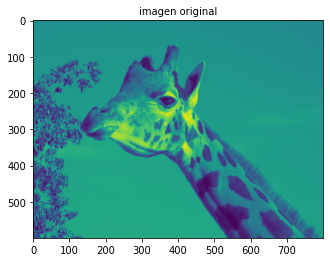

La variacion de la intencidad es de 0.013212730650490445


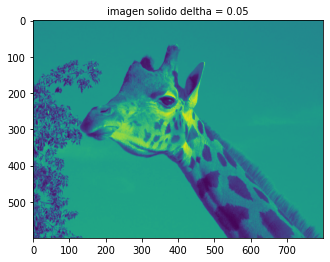

La variacion de la intencidad es de 0.039116769826729625


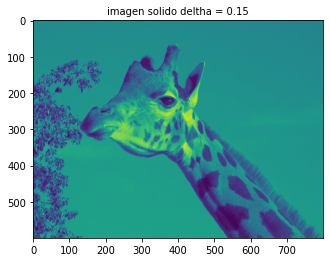

La variacion de la intencidad es de 0.06434080504822948


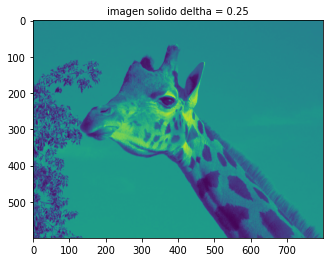

La variacion de la intencidad es de 0.1245418709022047


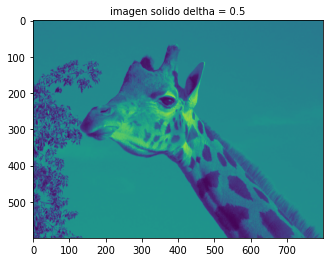

La variacion de la intencidad es de 0.1808695517143737


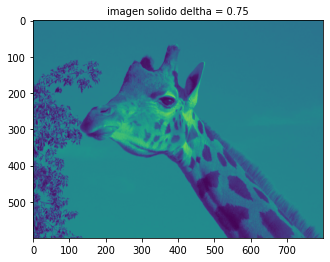

In [ ]:
#########################################################################################################################################################################################################################################################################
#Librerias 
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from matplotlib import pyplot as plt
import numpy as np 
import math 
import cv2
#########################################################################################################################################################################################################################################################################
#2.2 #utilice la informacion de la pregunta anterior con la finalidad de poder ser mas ilustrativo 
#########################################################################################################################################################################################################################################################################
#Librerias 
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from matplotlib import pyplot as plt
import numpy as np 
import math 
import cv2
#########################################################################################################################################################################################################################################################################
# la ley de Beer-Lambert permite determinar la concetracion de una especie quimica en funcion de la cantidad de energia absorvidad por el cuerpo 
#Para poder testear de manera efectiva el sistema ocuparemos la siguiente imagen de prueba:

#[importante]link para descargar la imagen = https://cdn.discordapp.com/attachments/746447509924216862/1019008870124900392/jirafa.jpg
#########################################################################################################################################################################################################################################################################
tarj = cv2.imread("jirafa.jpg",0)
img_original=cv2.imread("jirafa.jpg",0)
#########################################################################################################################################################################################################################################################################
#funciones importantes 
def fftc(X):
    return fftshift(fft2(ifftshift(X)))
def ifftc(X):
    return fftshift(ifft2(ifftshift(X)))

def BeerLambert(img,deltha):
  #determinare una funcion que calculara para cada punto de la funcion su imagen una vez disipada la energia al cuerpo.
  #Intensidad=Intensidad_0*E^integral de coedifiente de absorcion lineal 
  #como el como estamos trabajando con un curpo que es homogeneo el coeficiente de atenuacion lineal es cte por lo cual resulta e^(delta*distancia)
  i_0=1
  d=1
  a=0.5
  l=0.25
  angulo=np.arctan(a/(l*1.5+d))
  distancia= l/np.cos(angulo)
  intencidad=i_0*math.e**(deltha*distancia*-1)
  TF=fftc(img) 
  TF=TF*intencidad**1# se puede editar este parametro para analizar mas a cabalidad la atenuacion 
  IFT=ifftc(TF) 
  print(f"La variacion de la intencidad es de {1-intencidad}")
  return IFT
#########################################################################################################################################################################################################################################################################
plt.title("imagen original")
plt.imshow(img_original)
plt.show()
lista=(0.05, 0.15, 0.25, 0.5,0.75)

for i in lista:
  imagen = BeerLambert(tarj ,i)
  plt.title(f"imagen solido deltha = {i}")
  plt.imshow(abs(imagen),vmin=0,vmax=250)
  plt.show()
########################################################################################################################################################################################################################################################################

###Ahora bien, una vez expliaco el comportamiento del fenome de atenuacion, podemos encaminarnos a enunciar como se comporta matematicamente la Intencidad de un rayo en funcion de la energia, es para esto que tenemos que plantear las siguientes 2 ecuaciones:

##1°:
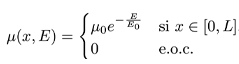

##2°:

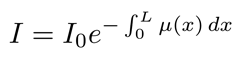

Al convinar ambas ecuaciones llegamos a formar:

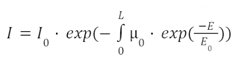



Como en el enunciado nos mencionas que estamos ante un material homogeneo, podemos simplificar la ecuacion a:

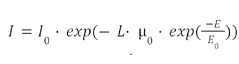

### De esta manera la variacion, tal y como se calculo en las imagenes va a resultar de la resta de I con I_0

#2.3

### Guiandonos por lo enunciado en la pregunta anterior y utlizando la ultima exprecion escrita, podemos definir la funcion solicitada como:
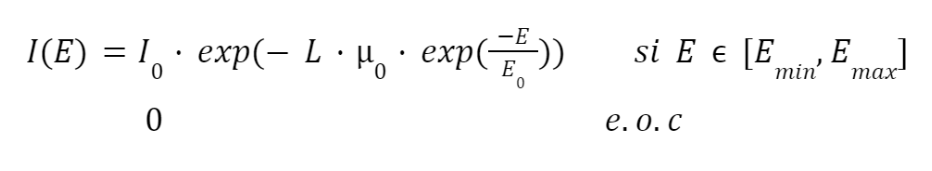

#2.4
### En primera intancia tenemos que entender que al trabajar con un rayo policromatico,se estan considerando multiples frecuencias  que se estan superponiendo de un mismo rayo. El problema se genera cuando los rayos indicen en un cuerpo, dado aque al tener distintas frecuencias dependiendo del material el procentaje de abosrcion variara en pos de la frecuencia del rayo. Es en este punto donde se genera una inconsistencia con el concepto de coediciente de atenuacion lineal, dado a que estamos condierando multiples perfiles energeticos. 

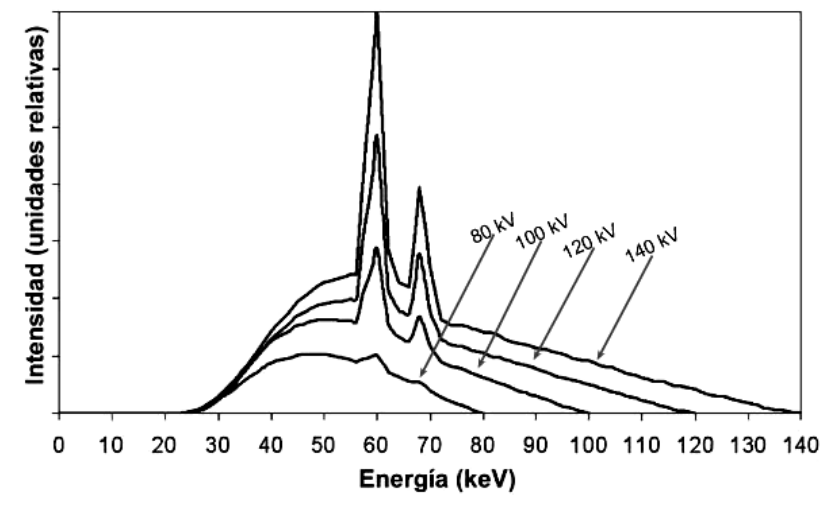
### Este fenomeno genera una sub-estimacion del modelo, lo cual proboca  una atenuacion de los rayos hacia el centro de la imagen. Como se muestra a continuacion:


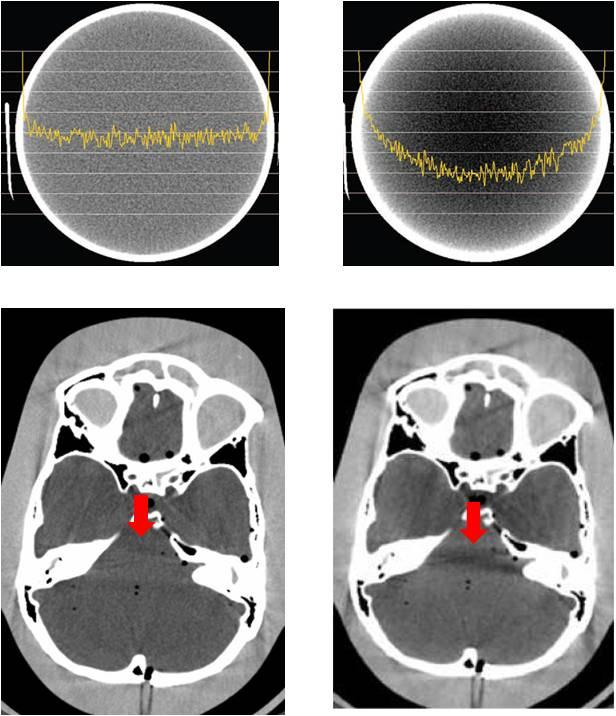

### tambien este fenomeno se puede generar cuando se esta analizando un cuerpo en movimieto, es por esto que un tratamiento adecuado para este problema es tener el objesto sentrado en el sistema, y estatico c, con el objetivo de analizar de manera efectiva el cuerpo 



## **➼ Codigo Preguna N°3**

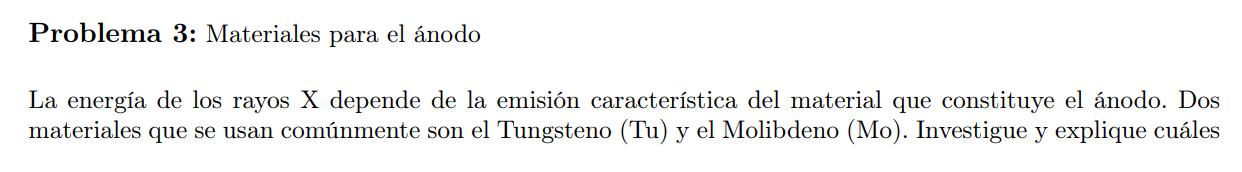

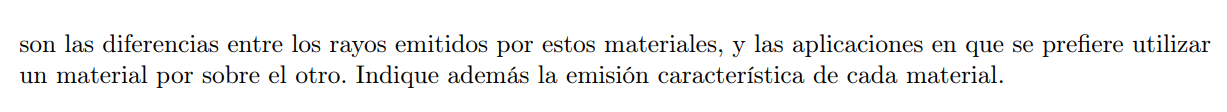





#3.1

### Dependiendo del material se e produce radiación característica cuando un electrón / proyectil arranca uno de los electrones más internos del átomo, ionizándolo, dicho proceso depende del material blanco. 

### Para esta experienecia analizaremos el caso del Tungsteno (Tu) y el Molibdeno (Mo) mencionando sus aplicaciones y caracteristicas:

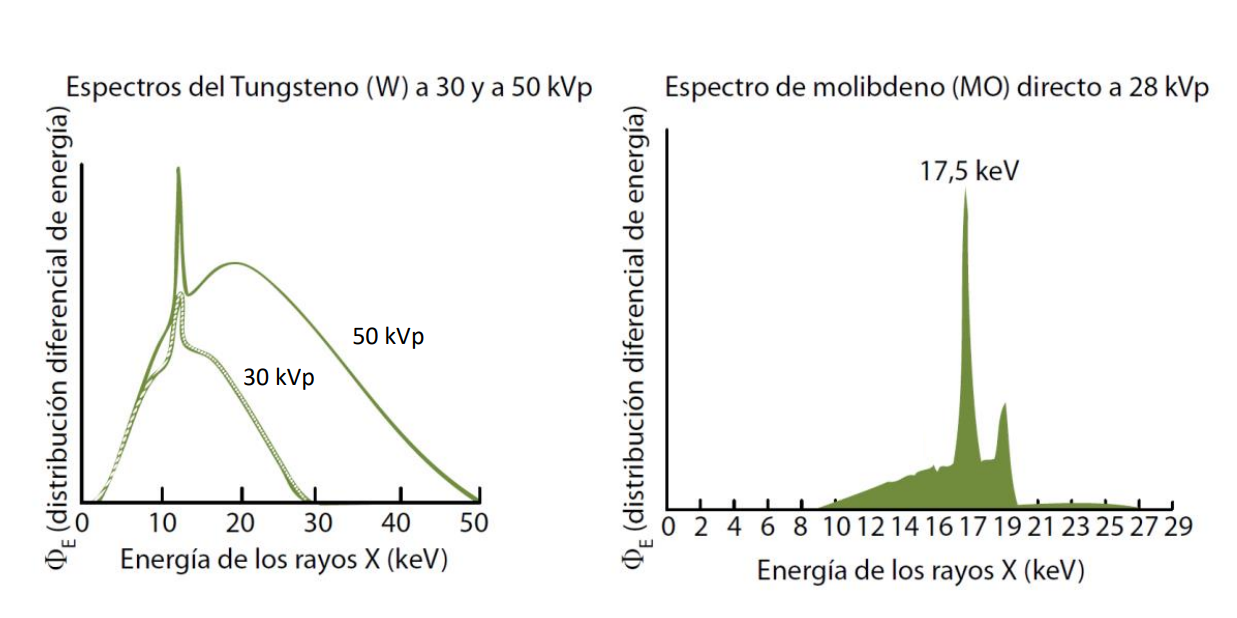

###La diferencia entre el objetivo de molibdeno y el objetivo de tungsteno:

###Anodo utilizado tubo de rayos X está hecho de molibdeno (MO) y ordinario ánodo de tubo de rayos X está hecho de tungsteno. El molibdeno tiene un bajo coeficiente atómico y después de que el bombardeo de electrones puede emitir energía de rayos X más baja y la longitud de onda de la línea espectral característica es más larga, lo que es adecuado para imágenes de transiluminación de tejidos blandos. El número atómico de tungsteno es mayor y el poder de penetración de electrones es fuerte, lo cual es adecuado para la obtención de imágenes radiográficas óseas.

###Por lo tanto la mamografía del blanco del molibdeno es conveniente para el examen de la mama, la mamografía de la radiografía es reconocida método eficaz mundial para la detección temprana del cáncer de pecho. Especialmente en la mamografía digital, podemos mostrar claramente el pecho a todos los niveles de la estructura fina, particularmente la calcificación fina

##Ejemplo tegido oseo :

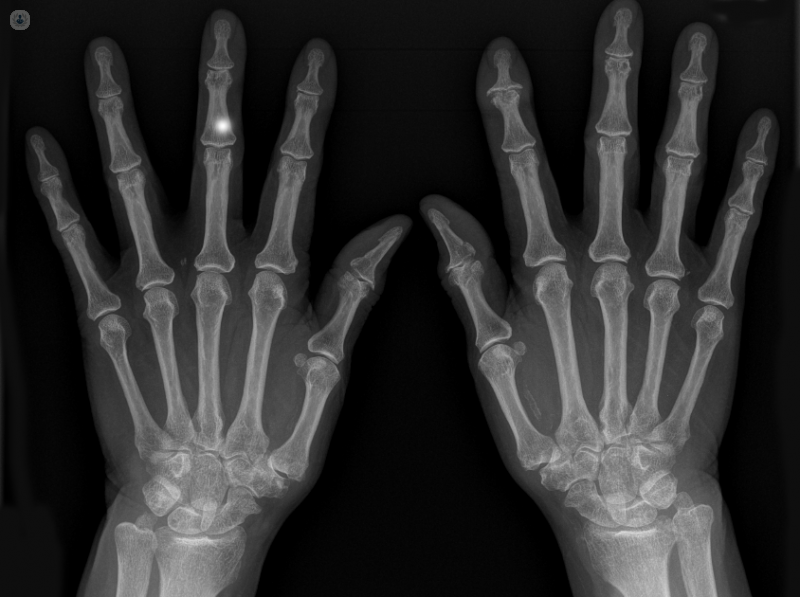

##Ejemplo tegido blando:
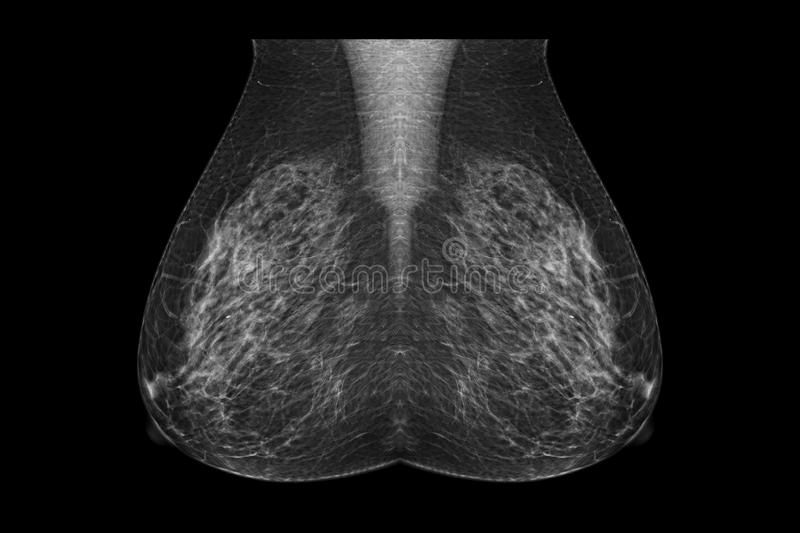







##bibliografia:
##### http://www.molybdenum.com.cn/Spanish/molybdenum-target-and-tungsten-target.html